# Notebook used to identify basket of stocks for sparse mean-reverting portfolio


# Optimal Selection of Sparse Mean-reverting Portfolios

## Intro
This work is inspired by the academic paper by Marco Cuturi and Alexandre d'Aspremont   ["Mean-Reverting Portfolios: Tradeoffs Between Sparsity and Volatility"](https://arxiv.org/abs/1509.05954). The paper describes multiple optimisation techniques that allow selecting sparse mean-reverting portfolios with pre-defined volatility characteristics. A numerical experiment included in the paper is based on historical data of daily implied volatility. The calculations below have extended the numerical experiment to mean-reverting portfolios of stock using a sample of S&P 500 companies. Additionally, it demonstrates the sensitivity of resulting portfolios to optimisation parameters that allowed for a better understanding of the internal structure of the approach.

We further focus on practical aspects of mean-reverting stock portfolio construction and include minimum theoretical facts to follow the logic. Please refer to Cuturi and d'Aspermont paper for more details behind the theory.

## Defining Target Portfolio

Our primary target is to build a portfolio that exhibits significant mean reversion. This portfolio includes long and short positions in multiple liquid stocks from a pre-defined universe. The portfolio is defined as a vector of weights that should be optimised in a way that allows for: <br>
- **Significant mean reversion**. The portfolio has to revert to the long-term mean. We control the level of mean reversion based on the p-value of *Augmented Dickey–Fuller test (ADF)*. This measure is not suitable for optimisation, hence different proxies based on stationarity measures are used.
- **Sufficient volatility**. A mean reversion trading strategy makes money on extreme deviations from a long-term mean. Hence we need a portfolio that deviates significantly from the long-term mean, so a potential trading strategy does not need to be highly-leveraged to be profitable.
- **Sparsity**. The portfolio requires trading of as few assets as possible, that will allow minimising cost. Going forward, we introduce a constraint for the maximum number of stocks in the portfolio.


In [6]:
!pip install yfinance --upgrade --no-cache-dir
!pip install statsmodels scipy pandas-datareader pandas numpy matplotlib cvxpy scikit-learn fix-yahoo-finance
import yfinance as yf


  Preparing metadata (setup.py) ... done
  Created wheel for fix-yahoo-finance: filename=fix_yahoo_finance-0.1.37-py3-none-any.whl size=7074 sha256=8e0b0766518521f1a7cb5b290f5a896ea1d1feabe508bd500cfb46902c87694f
  Stored in directory: /Users/darien/Library/Caches/pip/wheels/1e/5e/ca/d9dbe97f5c895289286a5f99311e9e9633c9898f35d42802ca
Successfully built fix-yahoo-finance


In [7]:
%matplotlib inline
# Imports
from datetime import datetime, timedelta, date
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy import linalg as LA
import time
from scipy.stats.stats import pearsonr

import cvxpy as cp
from sklearn.decomposition import SparsePCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Source Data

We begin with downloading historical adjusted close prices of a random sample of 50 symbols from the most recent S&P 500 index, using Yahoo Finance as a data source. Historical period is from _1-Jan-2018_ to _1-Jun-2019_.

Theoretically, the approach is scalable and should allow building a mean-reverting portfolio based on a larger base of stocks, but larger dataset will limit our ability to iterate quickly across multiple techniques.

In [8]:
#Get the most recent S&P 500 index from Wikipedia
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header=0)[0] # returns a list for each table


In [36]:
import fix_yahoo_finance
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# Top 10 stocks across 3 sectors in s&p 500
symbols_top_snp = ['BA', 'CAT', 'GE', 'HON', 'LMT', 'DE', 'DAL', 'UNP', 'FDX', 'RTX', 'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP',  'SCHW', 'BLK', 'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'V', 'MA', 'INTC', 'ADBE', 'CRM', 'ORCL']
symbols = [x for x in sp.Symbol if x.find(".")==-1]

symbols_top_snp



['BA',
 'CAT',
 'GE',
 'HON',
 'LMT',
 'DE',
 'DAL',
 'UNP',
 'FDX',
 'RTX',
 'JPM',
 'BAC',
 'WFC',
 'C',
 'GS',
 'MS',
 'AXP',
 'SCHW',
 'BLK',
 'AAPL',
 'MSFT',
 'GOOGL',
 'NVDA',
 'V',
 'MA',
 'INTC',
 'ADBE',
 'CRM',
 'ORCL']

In [23]:
# symbols = [x for x in sp.Symbol if x.find(".")==-1]
random.seed(123)
np.random.seed(5)
# assets_list_short = random.sample(symbols, 50)
# set the assets list to the top 30 S&P 500 companies by top 10 per sector
assets_list_short = symbols_top_snp
print('Assets selected: {}'.format(assets_list_short))

start = datetime(2021, 1, 1)
end = datetime(2024, 3, 31)
src_data = pdr.get_data_yahoo(assets_list_short,  start=start, end=end)

#Simple impute
from sklearn.impute import SimpleImputer
s_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

#Keep only adjusted close price and convert to Numpy array
x_array = np.array(src_data['Adj Close'])
x_array = s_imp.fit_transform(x_array)
# Centered data
x_array_centered = x_array - np.nanmean(x_array, axis=0)


[**********************52%%                      ]  15 of 29 completed

Assets selected: ['BA', 'CAT', 'GE', 'HON', 'LMT', 'DE', 'DAL', 'UNP', 'FDX', 'RTX', 'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'SCHW', 'BLK', 'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'V', 'MA', 'INTC', 'ADBE', 'CRM', 'ORCL']


[*********************100%%**********************]  29 of 29 completed


## Utility Functions



### Autocovariance Matrix for Multivariate Process

All of the techniques below use lagged autocovariance matrices as core building blocks. An empirical lag-k autocovariance matrix for a multivariate time series $\{x_t\}$ is defined as follows:

$A_k=\frac{1}{T-k-1}\sum_{t=1}^{T-k} \tilde{x}_t\tilde{x}_{t+k}^T$, <br>
$\tilde{x_t}=x_t-\frac{1}{T}\sum_{t=1}^{T}x_t$

In [24]:
# Build autocovariance matrix
def autocovariance_matrix(x, k=0):
    T = x.shape[0]
    x_tilde = x - np.nanmean(x, axis=0)

    x_0 = x_tilde[0,:].reshape((1,x_tilde.shape[1]))

    if k > 0:
        A_k = 1/(T - k - 1) * np.dot(x_tilde[k:,:].transpose(), x_tilde[:-k])
    else:
        A_k = 1/(T - 1) * np.dot(x_tilde.transpose(), x_tilde)
    return A_k


In [25]:

autocovariance_matrix(x_array, 0).shape


(29, 29)

### Plot Time Series and Present Basic Performance Stats

We use the function below to inspect the performance of the resulting portfolios. As mentioned, we are focusing on variance and ADF p-value as primary performance measures of the portfolio.

In [26]:
# Plot time series with basic stats
def plot_mr_ts(ts, label):
    var_ = np.var(ts)
    adf_ = adfuller(ts)
    plt.plot(ts, label='{}; Var:{:.0f} ADF p:{:.3f}'.format(label, var_, adf_[1]))
    plt.ylabel('Close')
    plt.legend()
    plt.show()


## Proxies for Mean Reversion

Given a multivariate n-dimensional time series $x=\{x_t\}$, we need to find the weights $y = \{y_1...y_n\}$ such that the univariate time series $(y^Tx_t )$ is stationary.
Following Cuturi and d'Aspermont we define two proxies for stationarity of time series to derive the optimal values of $y$: <br>
- Predictability
- Portmanteau criterion



### Predictability

We target to minimise predictability of the univariate process $(y^T, x_t)_t$, with weights $y \in \mathbb{R}^n$.
General predictability is defined based on the time series decomposition
${x}_t = \hat{x}_{t-1} + \varepsilon_t$
, where $\hat{x}_{t-1}$ is a predictor of $x_t$ built upon past values recorded up to $t-1$.

Predictability is defined as $\lambda = \frac{\hat{\sigma}^2}{\sigma}$
, where $\sigma^2$ and $\hat{\sigma}^2$ are variances of ${x}_t$ and $\hat{x}_{t-1}$ respetively. <br>
If we assume the process to be _VAR(1)_, this task is equivalent to computing the smallest eigenvector of the _prediction matrix_ $A_0^{-1/2}A_1A_0^{-1}A_1^TA_0^{-1/2}$, where $A_0, A_1$ are 0- and 1-lag autocovariance matrices respectively.
Below we demonstrate the portfolio derived from the source data based on minimum predictability criterion. Note we don't control sparsity and volatility at this stage.

In [27]:
A0 = autocovariance_matrix(x_array, 0)
A1 = autocovariance_matrix(x_array, 1)


In [28]:
# Minimise predictability
A0_inv = LA.inv(A0)
A0_inv_sqrt = sqrtm(A0_inv)

pred_mat = A0_inv_sqrt.dot(A1).dot(A0_inv).dot(np.transpose(A1)).dot(A0_inv_sqrt)

v, w = LA.eig(pred_mat)
min_eig = w[np.argmin(v)]
max_eig = w[np.argmax(v)]

print("Eigenvalues of prediction matrix:")
print(v)


Eigenvalues of prediction matrix:
[0.53999168 0.59112066 0.67134339 0.67973942 0.71539727 0.74385195
 0.76039591 0.7707516  0.80294053 0.81496607 0.82321931 0.85118905
 0.8663892  0.89083916 0.90068231 0.90426987 0.92760918 0.93616881
 0.94528107 0.95382528 1.0001149  0.99910256 0.99456203 0.99245684
 0.98748856 0.98070599 0.97672883 0.96155528 0.96875266]


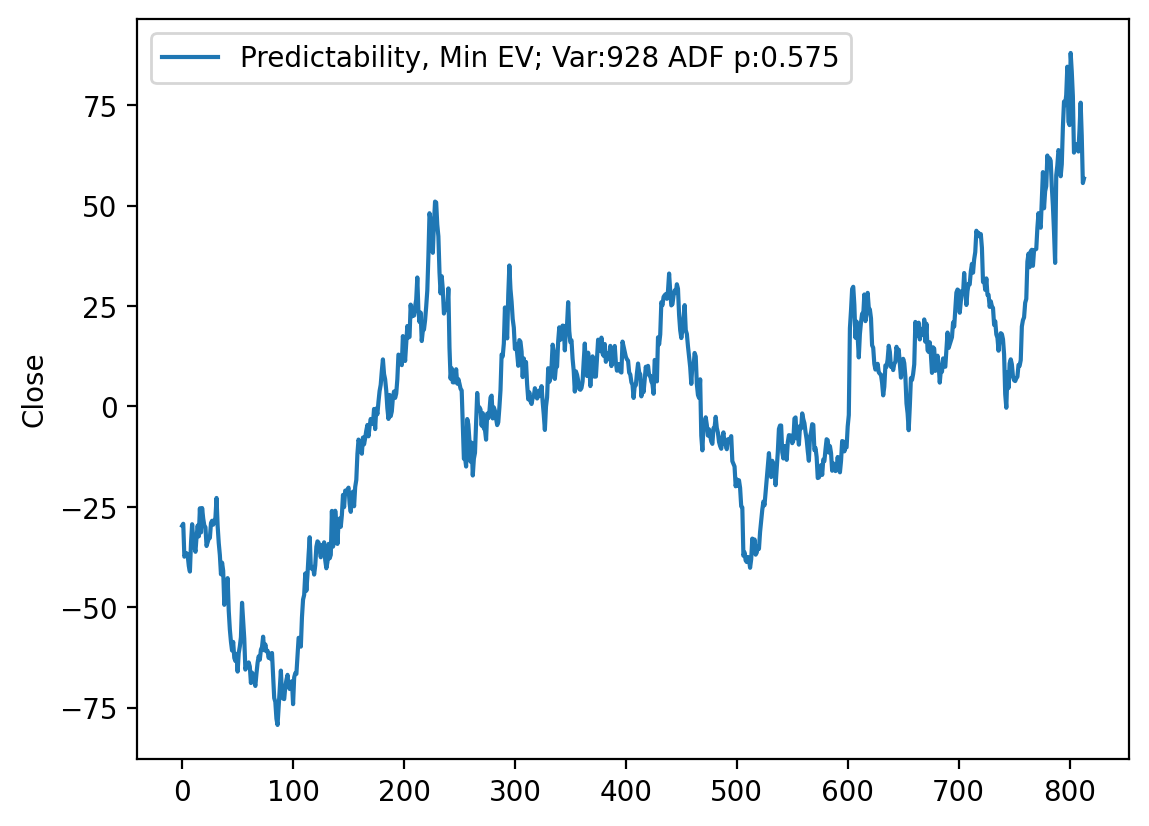

In [29]:
mr_portf_min = x_array_centered.dot(min_eig)
mr_portf_max = x_array_centered.dot(max_eig)

plot_mr_ts(mr_portf_min, 'Predictability, Min EV')


The graph presents the performance of the derived portfolio. As can be observed, the result is poor in terms of mean-reversion properties, with very high ADF p-value.

### Portmanteau Criterion

Portmanteau criterion relaxes the requirement for a process to be _VAR(1)_ as defined in Predictability-based calculation above. Portmanteau statistic of order $p$ of a centered multivariate process is defined as <br>
$por_p(y^Tx)=\frac{1}{p}\sum_{i=1}^{p}{(\frac{y^TA_iy}{y^TA_0y})}^2$  
In univariate settings Portmanteau criterion corresponds to the average of up to lag-p squared autocorrelations.
There is no closed form solution for minimum Portmanteau criterion, so to demonstrate its work we select two stocks that exhibit the lowest and highest Portmanteau statistics of order 5.

In [30]:
#Portmanteau criterion for univariate time series
def portmanteau(ts_array, n):
    '''
    ts_array = multivariate time series
    n = order of Portmanteau statistics to be calculated
    '''
    autocorr = [pearsonr(ts_array[:-t], ts_array[t:])[0] for t in range(1, n + 1)]
    return np.sum(np.square(autocorr)) / n


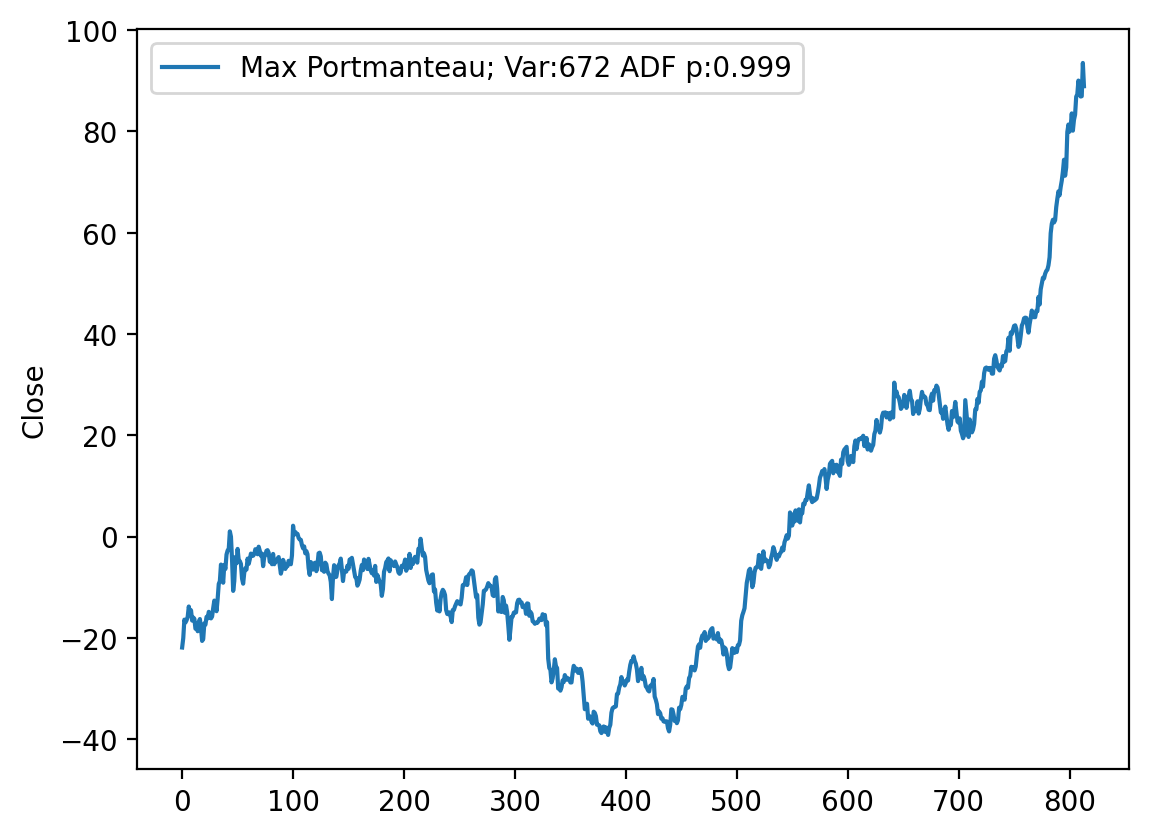

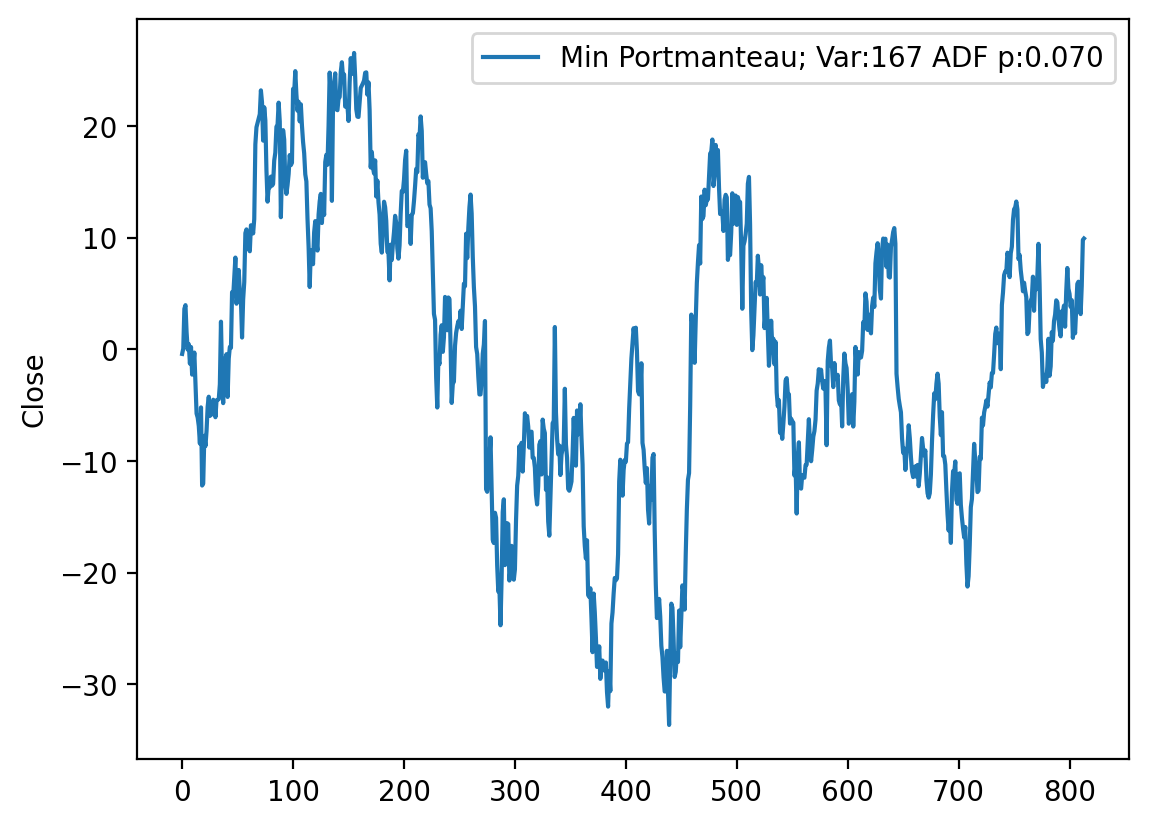

In [31]:
#Find the most and the least mean-reverting stock as per Portmenteau statistic
x_centered = x_array - np.nanmean(x_array, axis=0)
pmt_symb = [portmanteau(x_centered[:, i], 50) for i in range(x_centered.shape[1])]

plot_mr_ts(x_centered[:, np.argmax(pmt_symb)], 'Max Portmanteau')
plot_mr_ts(x_centered[:, np.argmin(pmt_symb)], 'Min Portmanteau')


Portmanteau statistics allows selecting stocks with good mean reversion characteristics. We further move on to apply Predictability and Portmanteau statistics to derive optimal mean-reverting portfolios.

## Optimal Mean Reverting Portfolio

Optimisation task to derive optimal mean reverting portfolios under variance and sparsity constraints for both Predictability and Portmanteau criterion are formulated in [Cuturi and d'Aspremont]. It is noted that both problems are non-convex since they involve sparse selection of variables. Base on this it is suggested to apply convex relaxation of these problems. This results in semidefinite programs (SDPs) as presented below:<br>
- **Predictability:** <br>
minimise $Tr(MY) + \rho\|Y\|_1$ <br>
subject to $Tr(A_0Y) \ge \nu$ <br>
$Tr(Y) = 1, Y \succcurlyeq 0$
- **Portmanteau:** <br>
minimise $\sum_{i=1}^p{Tr(A_iY)^2} + \rho\|Y\|_1$ <br>
subject to $Tr(A_0Y) \ge \nu$ <br>
$Tr(Y) = 1, Y \succcurlyeq 0$

In the tasks above <br>
- $Y$ is the target $n\times n$ positive semidefinite matrix
- $\nu$ is the minimum required variance of the resulting portfolio
- $\rho$ is the weight of penalty for L1-norm of $Y$
- $M=A_1A_0^{-1}A_1^T$

With nonnegative $\rho$ the optimiser will try to shrink $Y$ that theoretically should result in a sparser portfolio. <br>
Compared to the original definition of the optimisation problem, we replaced the _L1_ norm with _L2_ norm in the target function for the Portmanteau criterion. This allowed for better convergence and quicker solving of the optimisation task. As demonstrated further, _L2_ norm still performs well in shrinking $Y$ and provides for a sparser portfolio.
We further recover the solution $y^*$ from the corresponding SDP solution $Y^*$. As suggested in [Cuturi and d'Aspremont], we use _Sparse PCA_ process to derive $y^*$ as a maximum sparse principal component of $Y^*$.<br> Sparse PCA implementation in _scikit-learn_ package relies on the parameter _alpha_ to define the level of the sparsity of resulting principal components.

The optimisation tasks are solved using __[CVXPY](https://www.cvxpy.org/index.html)__ package. In all cases below, we require minimum required variance $\nu$ of _50_ and keep $\rho$ to be _1_. We set _alpa_ parameter of Sparse PCA to be _0.05_. These parameters are taken arbitrarily to demonstrate the approach. We further analyse the impact of $\rho$ on the optimisation results and also demonstrate the connection between $\rho$ and _alpha_.


### Predictability Criterion

In [32]:
M = A1.dot(A0_inv).dot(np.transpose(A1))

Y = cp.Variable(M.shape, symmetric=True)
rho = 1 #weight of l1 norm penalty
nu = 50 #minimum required variance


target_pred = cp.trace(M @ Y) + rho * cp.norm(Y, 1)

constraints_pred = [Y >> 0]
constraints_pred += [cp.trace(A0 @ Y) >= nu]
constraints_pred += [cp.trace(Y) == 1]

prob_pred = cp.Problem(cp.Minimize(target_pred),
                       constraints_pred)

prob_pred.solve()

Y_pred = Y.value


/Users/darien/miniforge3/envs/TradingPrj/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [34]:
sp_pca = SparsePCA(n_components=1, alpha=0.05)
sp_pca.fit(Y_pred)
print("Maximum sparse principal component:")
print(sp_pca.components_[0])
n_stock_pred = np.sum([x != 0 for x in sp_pca.components_[0]])
wgt_pred = sp_pca.components_[0]/sum(sp_pca.components_[0])
print("Total number of stocks in portfolio: {}".format(n_stock_pred))

portfolio_symbols = []
for ticker, x in zip(symbols_top_snp, sp_pca.components_[0]):
  if x != 0:
    portfolio_symbols.append(ticker)

display(portfolio_symbols)


Maximum sparse principal component:
[ 0.          0.         -0.42039903 -0.19831867  0.          0.01375798
  0.         -0.2254093   0.41935965  0.          0.19730262 -0.06591314
 -0.2180533  -0.05811436 -0.11724583 -0.26973073 -0.05127415  0.
  0.07220424  0.56282854  0.         -0.08326187  0.          0.
  0.          0.05761163  0.          0.20372649  0.        ]
Total number of stocks in portfolio: 17


['GE',
 'HON',
 'DE',
 'UNP',
 'FDX',
 'JPM',
 'BAC',
 'WFC',
 'C',
 'GS',
 'MS',
 'AXP',
 'BLK',
 'AAPL',
 'GOOGL',
 'INTC',
 'CRM']

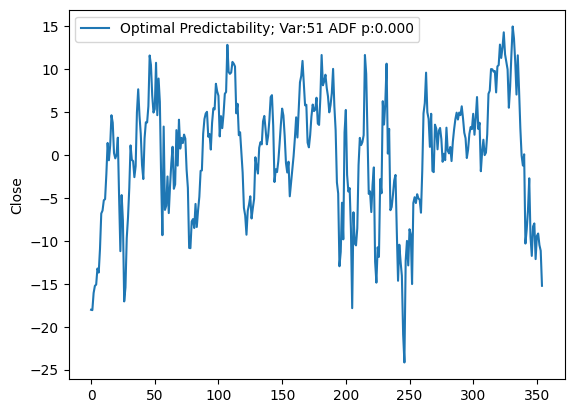

In [ ]:
mr_pred = x_array_centered.dot(wgt_pred)
plot_mr_ts(mr_pred, 'Optimal Predictability')


We can observe the resulting portfolio is both sufficiently mean reverting and volatile. Target variance is achieved using a sparse portfolio of 17 stocks.